# Overview

## Objective

## Data Description

## Import Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [6]:
# set the base directory for the data
base_dir = os.path.expanduser("~/projects/flatiron_p4/capstone/data/chest_xray")

# set the training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Preprocessing

### **IMG_SIZE** and **BAT_SIZE**
- X-ray images come in different resolutions.
- CNNs require a fixed input size.
- Downsampling to 150x150 balances computational cost and image detail.

In [7]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

### Load Data

In [8]:
# Load the dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "data/chest_xray/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


### Sanity Check
- Check that the data is loaded correctly
- Check out the classes
- Visualize a few of the images in the dataset

In [9]:
# Check class names (should be ["NORMAL", "PNEUMONIA"])
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


2025-02-24 21:04:52.292826: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


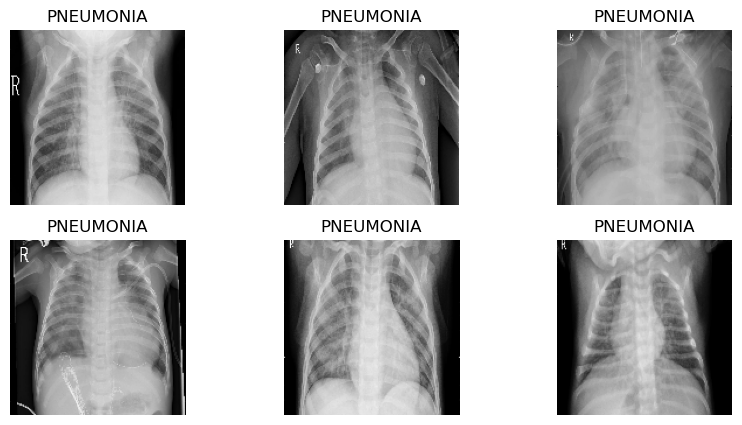

In [10]:
# Visualize some images
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### Augmentation and Scaling
- Reduce overfitting by using data augmentation (Generalization)
    - Prevents overfitting (since CNNs can memorize training images).
    - Simulates real-world variations like small rotations or shifts.
    - Helps the model generalize better to unseen images.
- Normalize the pixel values to be between 0 and 1 from 0 to 255 by dividing by 255

In [11]:
# normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)

# apply data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# prefetch for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building
We will use a Convolutional Neural Network (CNN) to classify the images. A Convolutional Neural Network (CNN) is ideal for image classification because it extracts features (like edges, textures, and shapes) using convolutional layers. 

We will leverage a moderate CNN with the following layers:

- Convolutional Layers (Conv2D)
    - Detects patterns like edges, textures, and shapes.
    - Uses small filters (kernels) (e.g., 3x3) to scan the image.
    - Activation function: ReLU (Rectified Linear Unit) (removes negative values to introduce non-linearity).

- Pooling Layers (MaxPooling2D)
    - Reduces spatial size while keeping important features.
    - Helps prevent overfitting and improves computational efficiency.
    - Common choice: MaxPooling (2x2).

- Dropout Layers
    - Randomly turns off neurons during training.
    - Helps prevent overfitting by forcing the model to generalize.

- Fully Connected Layers (Dense)
    - Takes extracted features and makes predictions.
    - Last layer uses Softmax (for multi-class classification) or Sigmoid (for binary classification).